In [1]:
# Data visualization dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

# Data analytics libraries
import numpy as np
import pandas as pd

# other dependencies
import datetime as dt
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy.sql import select
from sqlalchemy import and_
from sqlalchemy import between

In [3]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [4]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [5]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

([], <a list of 0 Text xticklabel objects>)

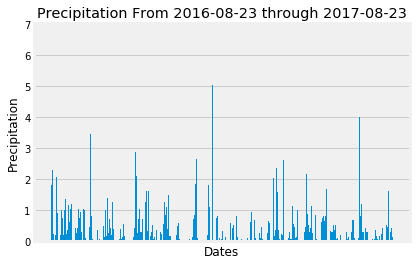

In [8]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
# query for the latest date
latest_date_max = session.query(func.max(Measurement.date)).scalar()
# convert the latest date to a datetime object
latest_date = dt.datetime.strptime(latest_date_max, '%Y-%m-%d').date()
# use timedelta to find the date 1 year ago
year_ago = latest_date - dt.timedelta(days=365)

# Create SQL query that will store the dates between year_ago and latest_date 
precipitation_query = select([Measurement.date, Measurement.prcp]).\
where(between(Measurement.date, year_ago,latest_date))

# Store the query values into a data frame and set the index as the date
conn = engine.connect()
precipitation_df = pd.read_sql(precipitation_query, conn)
precipitation_df = precipitation_df.set_index('date')

# plot the results
labels = precipitation_df.index
precip_data = precipitation_df['prcp']
plt.bar(labels, precip_data)
plt.title(f"Precipitation From {year_ago} through {latest_date}")
plt.xlabel("Dates")
plt.ylabel("Precipitation")
plt.xticks([], [])

In [9]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_summary_df = precipitation_df.describe()

# Output to JN window
precipitation_summary_df

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [10]:
# Count the number of unique stations
number_of_stations = session.query(Measurement.station).group_by(Measurement.station).count()

print(f"There are {number_of_stations} stations in the dataset.")

There are 9 stations in the dataset.


In [11]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

# Design a query to show how many stations are available in this dataset?
station_query = select([Measurement.station, func.count(Measurement.station)])\
.group_by(Measurement.station).order_by(func.count(Measurement.station).desc())

# Store the query in a dataframe and output to JN
station_count_df = pd.read_sql(station_query, conn)
station_count_df = station_count_df.rename(columns = {"count_1" : "count"})

# output to JN
station_count_df

,station,count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [12]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

# get the station tag of the station with the most amount of records
station_tag = station_count_df.iloc[1,0]

# Query for all the temperature data
station_query = select([Measurement.tobs]).where(Measurement.station == station_tag)

# Read the query into a dataframe and 
max_station_temp_df = pd.read_sql(station_query,conn)
max_temp = max(max_station_temp_df["tobs"])
min_temp = min(max_station_temp_df["tobs"])
avg_temp = round(max_station_temp_df["tobs"].mean(), 1)

# print stats to JN
print(f"MAX, MIN, and AVG temperature for {station_tag} station:")
print(f"MAX: {max_temp}")
print(f"MIN: {min_temp}")
print(f"AVG: {avg_temp}")

MAX, MIN, and AVG temperature for USC00519397 station:
MAX: 87.0
MIN: 56.0
AVG: 74.6


Text(0.5, 0, 'Temperature [F]')

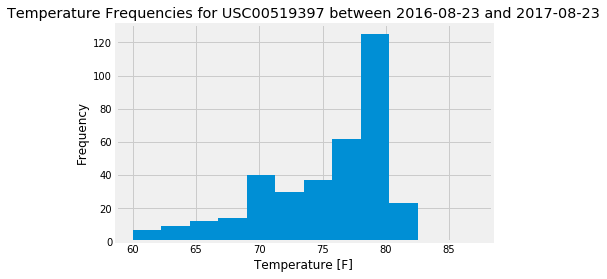

In [13]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# create a query 
temperature_query = select([Measurement.date, Measurement.tobs]).\
where(and_(Measurement.station == station_tag, between(Measurement.date, year_ago,latest_date)))

# Store the query in a dataframe
top_station_temps_df = pd.read_sql(temperature_query, conn)

# plot the results on a histogram
top_station_temps_df.hist(column='tobs', bins = 12)
plt.title(f"Temperature Frequencies for {station_tag} between {year_ago} and {latest_date}")
plt.ylabel("Frequency")
plt.xlabel("Temperature [F]")

In [14]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [15]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

# Store the summary data in the previous_year_stats list
previous_year_stats = calc_temps(year_ago, latest_date)

# Print to JN Output window
print(f"MAX, MIN, and AVG temperature for {station_tag} station between 2015-2016:")
print(f"MIN: {previous_year_stats[0][0]}")
print(f"AVG: {previous_year_stats[0][1]}")
print(f"MAX: {previous_year_stats[0][2]}")

MAX, MIN, and AVG temperature for USC00519397 station between 2015-2016:
MIN: 58.0
AVG: 74.59058295964125
MAX: 87.0


Text(0.5, 0, 'Date Ranges')

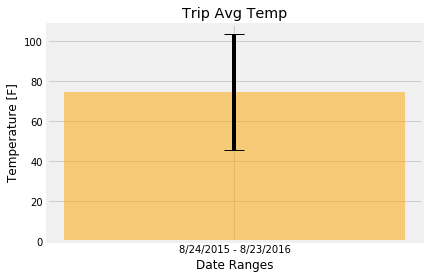

In [16]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
error = previous_year_stats[0][2] - previous_year_stats[0][0]
y_val = previous_year_stats[0][1]
labels = "8/24/2015 - 8/23/2016"
plt.bar(labels,y_val, yerr=error, align='center', alpha=0.5, color = "orange",ecolor='black', capsize=10)
plt.title("Trip Avg Temp")
plt.ylabel("Temperature [F]")
plt.xlabel("Date Ranges")

In [17]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

# Make queries to references of the tables Measurement and Station
# and store in a variable
prcp_station_query = select([Measurement.station, Measurement.date, Measurement.prcp]).\
                     where(between(Measurement.date, year_ago,latest_date))
station_info_query = select([Station.station, Station.latitude, Station.longitude, Station.elevation])

# store queries in dataframes
prcp_station_df = pd.read_sql(prcp_station_query, conn)
station_info_df = pd.read_sql(station_info_query, conn)

# inner join the tables so that each row includes latitude, longitude, and elevation data 
# as well as precipitation data for each station
temp_and_station_info_df = pd.merge(prcp_station_df,station_info_df, how = 'inner')

# create a new dataframe that groups the data by station and station geo coordinates 
# and shows the sum of the precipitation for each station
# sort in descending order
station_precipitation_df = temp_and_station_info_df.groupby(["station", "latitude", "longitude", "elevation"])\
                           .prcp.agg(["sum"])
station_precipitation_df.sort_values(by=['sum'], ascending=False)

# clean column header from aggregate function
station_precipitation_df = station_precipitation_df.rename(columns = {"sum":"Total Precipitation"})

# output to notebook
station_precipitation_df

,,,,Total Precipitation
station,latitude,longitude,elevation,
USC00513117,21.42340,-157.80150,14.6,48.51
USC00514830,21.52130,-157.83740,7.0,33.24
USC00516128,21.33310,-157.80250,152.4,147.81
USC00517948,21.39340,-157.97510,11.9,4.59
USC00519281,21.45167,-157.84889,32.9,70.03
USC00519397,21.27160,-157.81680,3.0,16.09
USC00519523,21.33556,-157.71139,19.5,38.01


In [18]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [19]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
date1 = dt.datetime(2019, 2, 1)
date2 = dt.datetime(2019, 2, 7)

# Use the start and end date to create a range of dates
date_dt_list = [date2 - dt.timedelta(days=x) for x in range(0, 7)]

# Stip off the year and save a list of %m-%d strings
date_str_list = []
for adate in date_dt_list:
    date_str_list.append(adate.strftime("%m-%d"))

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for aval in date_str_list:
    normals.append(daily_normals(aval))

normals

[[(60.0, 69.0, 77.0)],
 [(58.0, 70.38983050847457, 77.0)],
 [(59.0, 69.6842105263158, 80.0)],
 [(61.0, 68.14035087719299, 76.0)],
 [(58.0, 67.79661016949153, 77.0)],
 [(59.0, 68.85964912280701, 77.0)],
 [(56.0, 68.14035087719299, 78.0)]]

In [20]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

# create a dictionary out of the date strings and daily normals
date_normals_dict = dict(zip(date_str_list,normals))

# create a dataframe from the dictionary using the keys as rows
trip_dates_and_normals_df = pd.DataFrame.from_dict(date_normals_dict, orient = 'index')

# clean the df headers
trip_dates_and_normals_df.columns = ['Daily Normals']
trip_dates_and_normals_df.index.names = ["Trip Dates"]

# break up the tuples into 3 seperate columns
trip_dates_and_normals_df = pd.DataFrame(trip_dates_and_normals_df['Daily Normals'].tolist(), columns=['tmin', 'tavg','tmax'])
trip_dates_and_normals_df["Trip Dates"] = date_dt_list
trip_dates_and_normals_df = trip_dates_and_normals_df.sort_values(by=['Trip Dates'])
trip_dates_and_normals_df = trip_dates_and_normals_df.set_index('Trip Dates')

# output to notebook
trip_dates_and_normals_df

,tmin,tavg,tmax
Trip Dates,,,
2019-02-01,56.0,68.140351,78.0
2019-02-02,59.0,68.859649,77.0
2019-02-03,58.0,67.796610,77.0
2019-02-04,61.0,68.140351,76.0
2019-02-05,59.0,69.684211,80.0
2019-02-06,58.0,70.389831,77.0
2019-02-07,60.0,69.000000,77.0


Text(0, 0.5, 'Temperature [F]')

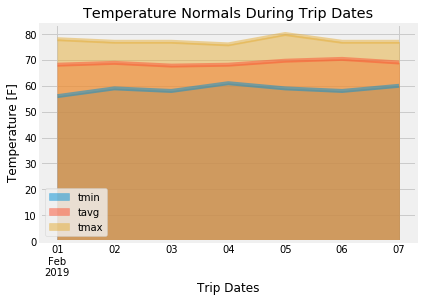

In [21]:
# Plot the daily normals as an area plot with `stacked=False`
trip_dates_and_normals_df.plot.area(stacked = False)
plt.title("Temperature Normals During Trip Dates")
plt.ylabel("Temperature [F]")